# Assignment 1

## Problem Background
For competing in a powerlifting meet, the probability of winning the game (taking the first prize only) could be different and unknown among multiple locations.<br> Therefore, the question is: **What is the best strategy (choose the meeting location) to achieve the highest long-term numbers of winning?**<br><br>
<*This problem is a Bernoulli trial problem since the success or win in this situation is take the first prize, otherwise, any other result from a competition would be considered as failure or loss.*>

In [1]:
# First we setup the necessary imports and the standard k-armed bandit. 
# The get_reward_regret samples the reward for the given action, and returns the regret based on the true best action.

import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

In [2]:
stationary=True
class Bandit():
    def __init__(self, loc_count):
        """
        Multi-armed bandit with rewards 1 or 0.

        At initialization, multiple arms are created. The probability of each arm
        returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
        chosen from Uniform(0,1) at initialization
            """
        self.loc_count = loc_count
        self.generate_thetas()
        self.timestep = 0
        global stationary
        self.stationary=stationary
    
    def generate_thetas(self):
        self.thetas = np.random.uniform(0,1,self.loc_count)
  
    def get_reward_regret(self, arm):
        """ Returns random reward for arm action. Assumes actions are 0-indexed
        Args:
          arm is an int
          """
        self.timestep += 1
        if (self.stationary==False) and (self.timestep%100 == 0):
            self.generate_thetas()
        # Simulate bernouilli sampling
        sim = np.random.uniform(0,1,self.loc_count)
        rewards = (sim<self.thetas).astype(int)
        reward = rewards[arm]
        regret = self.thetas.max() - self.thetas[arm]

        return reward, regret

In [18]:
class BetaAlgo():
    
    """
    The algos try to learn which Bandit arm is the best to maximize reward.

    It does this by modelling the distribution of the Bandit arms with a Beta, 
    assuming the true probability of success of an arm is Bernouilli distributed.
    """
    def __init__(self, bandit):
        """
        Args:
          bandit: the bandit class the algo is trying to model
        """
        self.bandit = bandit
        self.loc_count = bandit.loc_count
        self.alpha = np.ones(self.loc_count)
#         print("ini a")
#         print(self.alpha)
        
        self.beta = np.ones(self.loc_count)
#         print("ini b")
#         print(self.beta)
        
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
    
    def _update_params(self, arm, reward):
            self.alpha[arm] += reward
            self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)
        
    @staticmethod
    def name():
        return 'beta-greedy'
   
    def get_action(self):
        """ Bernouilli parameters are the expected values of the beta"""
        theta = self.alpha / (self.alpha + self.beta)
        return theta.argmax()

class BernThompson(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'thompson'
  
    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""

        
        theta = np.random.beta(self.alpha, self.beta)
        return theta.argmax()
    

### $\epsilon$-greedy algorithm

In [4]:
epsilon = 0.1
class EpsilonGreedy():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """
    def __init__(self, bandit):
        global epsilon
        self.epsilon = epsilon
        self.bandit = bandit
        self.loc_count = bandit.loc_count
        self.Q = np.zeros(self.loc_count) # q-value of actions
        self.N = np.zeros(self.loc_count) # action count
    
    @staticmethod
    def name():
        return 'epsilon-greedy'
  
    def get_action(self):
        if np.random.uniform(0,1) > self.epsilon:
            action = self.Q.argmax()
        else:
            action = np.random.randint(0, self.loc_count)
        return action
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### UCB

In [5]:
ucb_c = 2
class UCB():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """
    def __init__(self, bandit):
        global ucb_c
        self.ucb_c = ucb_c
        self.bandit = bandit
        self.loc_count = bandit.loc_count
        self.Q = np.zeros(self.loc_count) # q-value of actions
        self.N = np.zeros(self.loc_count) + 0.0001 # action count
        self.timestep = 1
  
    @staticmethod
    def name():
        return 'ucb'
  
    def get_action(self):
        ln_timestep = np.log(np.full(self.loc_count, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        return action
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

### Plot

In [12]:
def plot_data(y):
    """ y is a 1D vector """
    x = np.arange(y.size)
    _ = plt.plot(x, y, 'o')

def multi_plot_data(data, names):
    """ data, names are lists of vectors """
    x = np.arange(data[0].size)
    for i, y in enumerate(data):
        plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
    plt.xlabel("episode", fontsize = 14)
    plt.ylabel("regret", fontsize = 14)
    plt.show()

def simulate(simulations, timesteps, loc_count, Algorithm):
    """ Simulates the algorithm over 'simulations' epochs """
    sum_regrets = np.zeros(timesteps)
    for e in range(simulations):
        bandit = Bandit(loc_count)
        algo = Algorithm(bandit)
        regrets = np.zeros(timesteps)
        for i in range(timesteps):
            action = algo.get_action()
            reward, regret = algo.get_reward_regret(action)
            regrets[i] = regret
        sum_regrets += regrets  
    mean_regrets = sum_regrets / simulations
    return mean_regrets

def experiment(loc_count, timesteps=1000, simulations=1000):
    """ 
    Standard setup across all experiments 
    Args:
        timesteps: (int) how many steps for the algo to learn the bandit
        simulations: (int) number of epochs
    """
    algos = [EpsilonGreedy, UCB, BernThompson]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, loc_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

First, we set up a experiment as our baseline experiment, and the baseline parameters would be set as below:<br>
1. loc_count = 10 <br>
2. epsilon = 0.1 <br>
3. ucb_c = 2 <br>
4. stationary=True

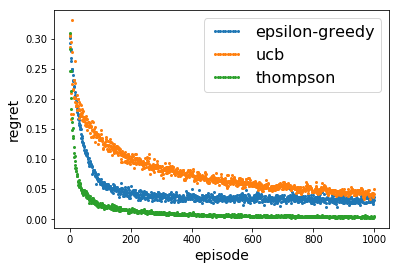

In [20]:
# Model 0 (Original Experiment 1)
loc_count = 4 # number of locations in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(loc_count)

### Code Adapted
1. Naming Schemes:<br>
[arm_count] --> [loc_count] (the number of locations)<br> <br>
2. Plot axises:<br>
x-axis: episode<br>
y-axis: regret

## Q1 
Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points)

**Thompson Sampling:** Beta Distribution. a (numbers of wins) and b (numbers of losses).<br>
**$\epsilon$-Greedy:** epsilon<br>
**UCB:** c (optimistic, or plausibly possible)<br>
**Random Sampling:** desired sample size

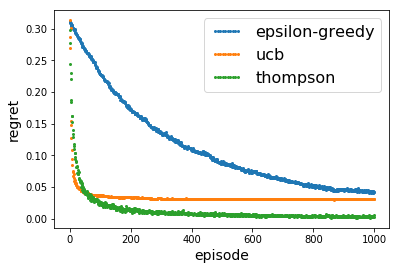

In [21]:
# Model 1
loc_count = 4 # number of locations in bandit
epsilon = 0.01
ucb_c = 0.1
stationary=True
experiment(loc_count)

We changed a few hyperparameters in Q1.<br>
For $\epsilon$-Greedy, we changed the epsilon from 0.1 -> 0.01. By reduce the exploration rate, we actually make it more greedy in this case. As we can see from the plot above, even though both experiments end around 0.05 regret after 1000 episodes, however, the greedier way takes longer to get there.<br>
From UCB, we changed the exploration parameter from 2 -> 1, also turn it into a greedier method. However, in this case, the UCB performs better when it is greedier.

## Q2
How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

In order to figure out how does the action space affect different methods, we can do that by changing the numbers of locations. We will use the Experiment Test setting as our baseline experiment, and keep all the other parameters remain the same, only increase the number of locations to 10, 50, 100 and 400.

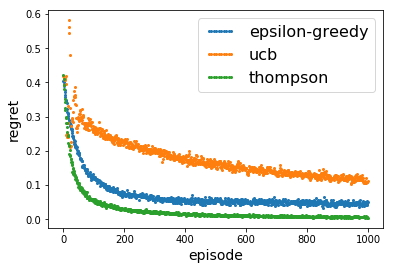

In [22]:
# Experiment 2
loc_count = 10 # number of locations in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(loc_count)

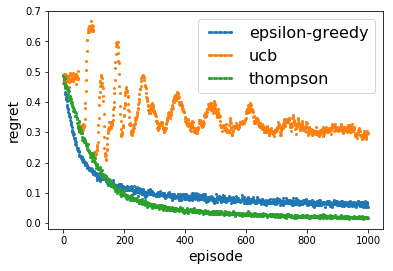

In [23]:
# Experiment 3
loc_count = 50 # number of locations in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(loc_count)

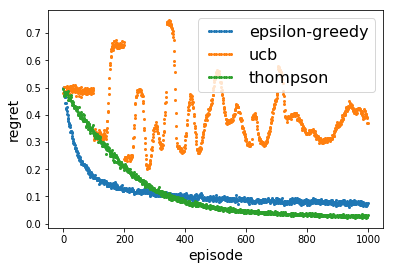

In [24]:
# Experiment 4
loc_count = 100 # number of locations in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(loc_count)

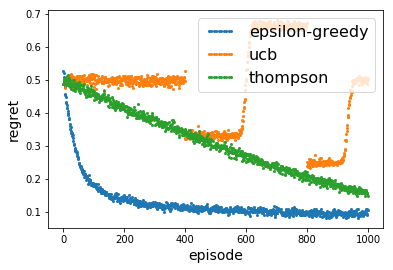

In [25]:
# Experiment 5
loc_count = 400 # number of locations in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(loc_count)

As we can see from the plots above, with the increasing of the numbers of locations, **Thompson Sampling** perform more and more worse. However, there is no significant changed for **$\epsilon$-Greedy**. And the **UCB** has the worst performance among these three methods, it becomes very unstable when the numbers of locations increase to 50.

## Q3
How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

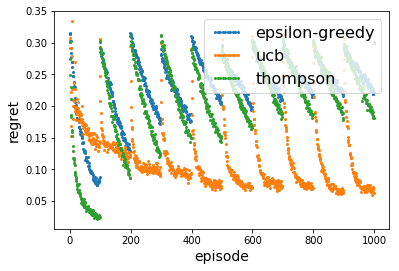

In [26]:
# Model 6 
loc_count = 4 # number of locations in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(loc_count)

By setting non-stationarity means that the probability of winning the competition on different locations changed about every 100 episodes. While the regret of **$\epsilon$-Greedy** and **Thompson Sampling** decrease dramatically for each time, on average they increase over time. However, **UCB** generally improve in regret over time.

In this new situation, I tried to change the parameters to make these methods greedier, which means make them explore more, and less greedy, which means exploited more.<br>
When decrease the epsilon and c parameters, these three methods have similar trends and getting worse for each time.<br>
On the other hand, when increase the epsilon value and the c parameter, the performance of **UCB** actually improve a lot. But the **$\epsilon$-Greedy** performance poorly.

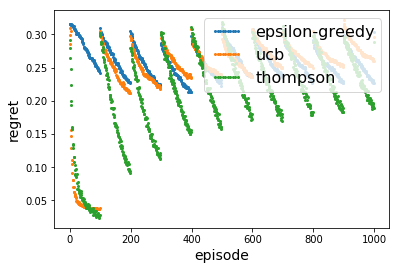

In [27]:
# Model 7 
loc_count = 4 # number of locations in bandit
epsilon = 0.01
ucb_c = 0.1
stationary=False
experiment(loc_count)

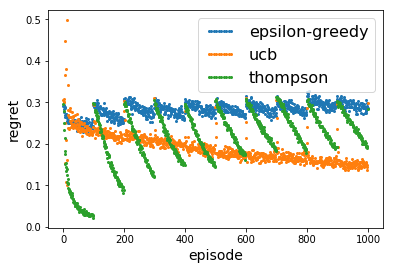

In [28]:
# Model 8
loc_count = 4 # number of locations in bandit
epsilon = 0.8
ucb_c = 5
stationary=False
experiment(loc_count)

## Q4
When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points)

When start by 100% exploring the environment, the percentage of exploring the environment would be decrease as the we learn more about the situation. The reason we stop exploring mostly because we already have a complete understanding of the environment. 

The exploration-exploitation trade-off occurs when an agent or a learning system has multiple options and has to make choices with uncertain pay-offs. In general, this problem is to make decision between whether to repeat decisions that have worked well so far, which means exploiting it, or trying new decisions, that is exploring the environment.

## Q5
How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points)

If we set the environment to stationary, then the algorithms can remember a long-term of past data. However, when we changed the environment to non-stationary, then it depend on the how many episodes are there before the probability changed.

## Q6
Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

In [45]:
#Define the total number of turns (i.e., the number of times we will play a slot machine).
#Remember, we have $1,000 available, and each turn costs $1. We thus have 1,000 turns.
number_of_turns = 1000

#define the total number of slot machines
number_of_slot_machines = 4

#Define arrays where we can keep track of our wins (positive rewards) 
#and losses (negative rewards) for each slot machine.
number_of_positive_rewards = np.zeros(number_of_slot_machines)
number_of_negative_rewards = np.zeros(number_of_slot_machines)

#define a seed for the random number generator (to ensure that results are reproducible)
np.random.seed(5)

#create a random conversion rate between 1% and 15% for each slot machine
conversion_rates = np.random.uniform(0.01, 0.15, number_of_slot_machines)

#Show conversion rates for each slot machine. Remember that in a real-world scenario
#the decision-maker would not know this information!
for i in range(4):
    print('Conversion rate for slot machine {0}: {1:.2%}'.format(i, conversion_rates[i]))

Conversion rate for slot machine 0: 4.11%
Conversion rate for slot machine 1: 13.19%
Conversion rate for slot machine 2: 3.89%
Conversion rate for slot machine 3: 13.86%


In [46]:
#The data set is a matrix with one row for each turn, and one column for each slot machine.
#Each item in the matrix represents the outcome of what would happen if we were to play a  
#particular slot machine on that particular turn. A value of "1" indicates that we would win, 
#while a value of "0" indicates that we would lose. The number of "wins" for each slot machine
#is determined by its conversion rate.
outcomes = np.zeros((number_of_turns, number_of_slot_machines)) #create a two-dimensional numpy array, and fill it with zeros
for turn_index in range(number_of_turns): #for each turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Get a random number between 0.0 and 1.0.
        #If the random number is less than or equal to this slot machine's conversion rate, then set the outcome to "1".
        #Otherwise, the outcome will be "0" because the entire matrix was initially filled with zeros.
        if np.random.rand() <= conversion_rates[slot_machine_index]:
            outcomes[turn_index][slot_machine_index] = 1

Below is the original beta distribution:

In [34]:
#for each turn

for turn_index in range(number_of_turns):
    index_of_machine_to_play = -1
    max_beta = -1 # note that max beta

    #determine which slot machine to play for this turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Define the shape parameters for the beta distribution. The shape will depend on the number
        #of wins and losses that have thus far been observed for this particular slot machine.
        a = number_of_positive_rewards[slot_machine_index] + 1
        b = number_of_negative_rewards[slot_machine_index] + 1


        #Get a random value from the beta distribution whose shape is defined by the number of
        #wins and losses that have thus far been observed for this slot machine
        random_beta = np.random.beta(a, b)

        #if this is the largest beta value thus far observed for this iteration
        if random_beta > max_beta:
            max_beta = random_beta #update the maximum beta value thus far observed
            index_of_machine_to_play = slot_machine_index #set the machine to play to the current machine
    
    #play the selected slot machine, and record whether we win or lose
    if outcomes[turn_index][index_of_machine_to_play] == 1:
        number_of_positive_rewards[index_of_machine_to_play] += 1
    else:
        number_of_negative_rewards[index_of_machine_to_play] += 1

print('Number of turns {0}:'.format(number_of_turns))  

#compute and display the total number of times each slot machine was played
number_of_times_played = number_of_positive_rewards + number_of_negative_rewards 
for slot_machine_index in range(number_of_slot_machines): #for each slot machine
    print('Slot machine {0} was played {1} times that is, {2:.2%}'.format(slot_machine_index, number_of_times_played[slot_machine_index], (number_of_times_played[slot_machine_index]/number_of_turns)))

#identify and display the best slot machine to play
print('\nOverall Conclusion: The best slot machine to play is machine {}!'.format(np.argmax(number_of_times_played)))

#show true conversion rate
for i in range(4):
    print('True conversion rate for column {0}: {1:.2%}'.format(i, conversion_rates[i]))  

Number of turns 1000:
Slot machine 0 was played 51.0 times that is, 5.10%
Slot machine 1 was played 72.0 times that is, 7.20%
Slot machine 2 was played 37.0 times that is, 3.70%
Slot machine 3 was played 840.0 times that is, 84.00%

Overall Conclusion: The best slot machine to play is machine 3!
True conversion rate for column 0: 4.11%
True conversion rate for column 1: 13.19%
True conversion rate for column 2: 3.89%
True conversion rate for column 3: 13.86%


While changing into normal distribution, the parameters are now mean(mu) and standard deviation(sigma).<br>
### Code Adapted
Parameters calculations of normal distribution.<br>
Distribution Function.

In [47]:
#for each turn

for turn_index in range(number_of_turns):
    index_of_machine_to_play = -1
    max_beta = -1 # note that max beta

    #determine which slot machine to play for this turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Define the shape parameters for the beta distribution. The shape will depend on the number
        #of wins and losses that have thus far been observed for this particular slot machine.
        mu = np.mean(outcomes)
        sigma = np.std(outcomes)


        #Get a random value from the beta distribution whose shape is defined by the number of
        #wins and losses that have thus far been observed for this slot machine
        random_normal = np.random.normal(mu, sigma)

        #if this is the largest beta value thus far observed for this iteration
        if random_normal > max_beta:
            max_beta = random_normal #update the maximum beta value thus far observed
            index_of_machine_to_play = slot_machine_index #set the machine to play to the current machine
    
    #play the selected slot machine, and record whether we win or lose
    if outcomes[turn_index][index_of_machine_to_play] == 1:
        number_of_positive_rewards[index_of_machine_to_play] += 1
    else:
        number_of_negative_rewards[index_of_machine_to_play] += 1

print('Number of turns {0}:'.format(number_of_turns))  

#compute and display the total number of times each slot machine was played
number_of_times_played = number_of_positive_rewards + number_of_negative_rewards 
for slot_machine_index in range(number_of_slot_machines): #for each slot machine
    print('Slot machine {0} was played {1} times that is, {2:.2%}'.format(slot_machine_index, number_of_times_played[slot_machine_index], (number_of_times_played[slot_machine_index]/number_of_turns)))

#identify and display the best slot machine to play
print('\nOverall Conclusion: The best slot machine to play is machine {}!'.format(np.argmax(number_of_times_played)))

#show true conversion rate
for i in range(4):
    print('True conversion rate for column {0}: {1:.2%}'.format(i, conversion_rates[i]))  

Number of turns 1000:
Slot machine 0 was played 231.0 times that is, 23.10%
Slot machine 1 was played 277.0 times that is, 27.70%
Slot machine 2 was played 245.0 times that is, 24.50%
Slot machine 3 was played 247.0 times that is, 24.70%

Overall Conclusion: The best slot machine to play is machine 1!
True conversion rate for column 0: 4.11%
True conversion rate for column 1: 13.19%
True conversion rate for column 2: 3.89%
True conversion rate for column 3: 13.86%


# Citations
https://colab.research.google.com/drive/1BHVH712x2Q2As9E5nN5Y8UR74T8w6AMO#scrollTo=B3AWpzsv6i8T
https://colab.research.google.com/drive/1gdR7k7jtSRqYnPNHcbAKdIjGRjQXpfnA#scrollTo=3tlM4eA5b85A

# License
Copyright 2020 Ruisi_Gu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.